In [ ]:
import numpy as np
import pandas as pd

In [ ]:
path = 'drive/MyDrive/Research/data_collection/final_cleaned/final_dataset.csv'
df = pd.read_csv(path)
df.head()

,fcp,interactive,srt,dom_size,but,fmp,tbt,tbw,fci,cls,lcp,ux_index,fid_category,lcp_category,fcp_category,cls_category
0,810.0,1623.000353,148.574,222,95.844,810.0,1.0,964194,1582.0,0.000000,890.0,810.000000,1,1,2,1
1,791.0,1938.500000,34.172,1049,574.117,1028.5,134.0,2463660,1604.0,0.000000,1623.0,1313.142001,1,1,2,1
2,660.0,1141.000000,309.005,1814,217.650,813.0,68.0,571401,1006.0,0.000800,1440.0,999.346206,1,1,2,1
3,655.0,3584.500000,348.280,1413,1686.482,726.0,484.0,1628682,3204.0,0.028540,820.0,1023.158693,1,2,2,1
4,770.0,3351.000000,775.957,1156,1554.168,770.0,537.0,1737243,3071.0,0.033484,2881.0,1869.895174,1,2,2,2


In [ ]:
df = df.drop([
  'cls', 'dom_size',
  "fid_category",
  "lcp_category",
  "fcp_category", 
  "cls_category"
],1)

df.head(3)

,fcp,interactive,srt,but,fmp,tbt,tbw,fci,lcp,ux_index
0,810.0,1623.000353,148.574,95.844,810.0,1.0,964194,1582.0,890.0,810.000000
1,791.0,1938.500000,34.172,574.117,1028.5,134.0,2463660,1604.0,1623.0,1313.142001
2,660.0,1141.000000,309.005,217.650,813.0,68.0,571401,1006.0,1440.0,999.346206


In [ ]:
# Computing IQR
Q1 = df['ux_index'].quantile(0.25)
Q3 = df['ux_index'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
df = df.query('(@Q1 - 1.5 * @IQR) <= ux_index <= (@Q3 + 1.5 * @IQR)')

In [ ]:
df.describe()

,fcp,interactive,srt,but,fmp,tbt,tbw,fci,lcp,ux_index
count,75762.000000,75762.000000,75762.000000,75762.000000,75762.000000,75762.000000,7.576200e+04,75762.000000,75762.000000,75762.000000
mean,932.827818,3961.247217,929.226237,1779.681090,1107.761351,349.240617,3.026213e+06,3246.381663,2466.179290,2853.481943
std,506.685031,3108.590147,815.101731,2142.225158,643.737603,596.723417,4.575173e+06,2421.332451,1850.041636,1552.752133
min,193.000000,193.000000,5.790000,0.000000,193.000000,0.000000,2.530000e+02,193.000000,194.000000,195.000000
25%,620.000000,1540.125000,354.125500,278.988250,704.000000,15.500000,1.079981e+06,1339.000000,1196.625000,1627.825928
50%,823.000000,3186.500000,752.994500,1014.001500,936.000000,141.500000,2.105680e+06,2633.000000,2020.000000,2599.659234
75%,1105.500000,5480.875000,1259.630500,2388.817750,1353.000000,450.500000,3.745136e+06,4515.000000,3155.000000,3803.281927
max,7147.000000,56131.000000,9862.042000,21218.420000,18650.000000,15656.500000,3.476087e+08,33366.000000,54185.000000,7350.324050


# **Decision Tree Regression**

In [ ]:
X = df.drop(["ux_index"], 1)
y = df['ux_index']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
(X_train.shape, y_train.shape)

((60609, 9), (60609,))

# **Generalization of Decision Tree**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

def decisionTreeGeneralization(X_, y_, ts, fold, md, msl):
  # Set SEED for reproducibility
  SEED = 1

  # Split the data into 70% train and 30% test
  X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=ts, random_state=SEED)

  # Instantiate a DecisionTreeRegressor dt
  dt = DecisionTreeRegressor(
      max_depth=md,
      min_samples_leaf=msl,
      random_state=SEED
  )

  # Compute the array containing the K-folds CV MSEs
  MSE_CV_scores = - cross_val_score(
      dt, X_train, y_train, cv=fold, 
      scoring='neg_mean_squared_error',
      n_jobs=-1
  )
  # Compute the 10-folds CV RMSE
  RMSE_CV = (MSE_CV_scores.mean())**(1/2)
  

  # Fit dt to the training set
  dt.fit(X_train, y_train)
  # Predict the labels of the training set
  y_pred_train = dt.predict(X_train)
  # Evaluate the training set RMSE of dt
  RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

  # Predict the labels of the training set
  y_pred_test = dt.predict(X_test)
  # Evaluate the training set RMSE of dt
  RMSE_test = (MSE(y_test, y_pred_test))**(1/2)


  return {
      'Minimum Sample Leaf': msl,
      'Max Tree Depth': md,
      'Fold': fold,
      'RMSE_CV': RMSE_CV,
      'RMSE_train': RMSE_train,
      'CV Error > Traning Error': RMSE_CV > RMSE_train,
      'RMSE_test': RMSE_test
  }

In [ ]:
result = [
 decisionTreeGeneralization(X, y, 0.3, 10, 2, 10),
 decisionTreeGeneralization(X, y, 0.3, 10, 3, 10),
 decisionTreeGeneralization(X, y, 0.3, 10, 4, 10),

 decisionTreeGeneralization(X, y, 0.3, 8, 2, 10),
 decisionTreeGeneralization(X, y, 0.3, 8, 3, 10),
 decisionTreeGeneralization(X, y, 0.3, 8, 4, 10),

 decisionTreeGeneralization(X, y, 0.3, 10, 2, 20),
 decisionTreeGeneralization(X, y, 0.3, 10, 3, 20),
 decisionTreeGeneralization(X, y, 0.3, 10, 4, 20),

 decisionTreeGeneralization(X, y, 0.3, 8, 2, 20),
 decisionTreeGeneralization(X, y, 0.3, 8, 3, 20),
 decisionTreeGeneralization(X, y, 0.3, 8, 4, 20)
]

generalization = pd.DataFrame(result)
generalization

,Minimum Sample Leaf,Max Tree Depth,Fold,RMSE_CV,RMSE_train,CV Error > Traning Error,RMSE_test
0,10,2,10,1025.741584,1024.057457,True,1018.743406
1,10,3,10,923.986663,920.011686,True,915.636590
2,10,4,10,854.070384,847.650328,True,846.476563
3,10,2,8,1026.039619,1024.057457,True,1018.743406
4,10,3,8,924.342893,920.011686,True,915.636590
5,10,4,8,855.384009,847.650328,True,846.476563
6,20,2,10,1025.741584,1024.057457,True,1018.743406
7,20,3,10,923.986663,920.011686,True,915.636590
8,20,4,10,854.070384,847.650328,True,846.476563
9,20,2,8,1026.039619,1024.057457,True,1018.743406


**From Generalization we get:**

- 10 Fold, 4 Depth Has Lowest RMSE_TEST
- 8 Fold, 4 Depth Has Lowest RMSE_CV, RMSE_TEST (Equal to 10F)

# Cross Validate

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from sklearn.tree import DecisionTreeRegressor
import math

In [ ]:
def dtregressor(X_, y_, ts, split, estimator):
  SEED = 42
  X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=ts, random_state=SEED)

  cv = KFold(
    n_splits=split,
    shuffle=True,
    random_state= SEED
  )

  dt_kfold = cross_validate(
      estimator, 
      X_train,
      y_train,
      scoring='r2', 
      cv=cv, 
      return_train_score = True, 
      n_jobs=-1
  )

  dt_kfold_rmse = cross_validate(
      estimator, 
      X_train,
      y_train,
      scoring='neg_mean_squared_error', 
      cv=cv, 
      return_train_score = True, 
      n_jobs=-1
  )

  return {
      'min_sample_leaf': estimator.min_samples_leaf,
      'fold': split,
      'mean_test_accuracy_r2': np.mean(np.array(dt_kfold['test_score'])) * 100,
      'mean_test_accuracy_rmse': math.sqrt(np.mean(np.array(dt_kfold_rmse['test_score'])) * -1),
      'mean_training_accuracy_r2': np.mean(np.array(dt_kfold['train_score'])) * 100
  }

In [ ]:
result = [
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor()),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=10)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=15)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=20)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=25)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=30)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=40)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=50)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=90)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=150)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=200)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=300)),
  dtregressor(X, y, 0.2, 8, DecisionTreeRegressor(min_samples_leaf=400))
]

dt_reg_df = pd.DataFrame(result)
dt_reg_df

,min_sample_leaf,fold,mean_test_accuracy_r2,mean_test_accuracy_rmse,mean_training_accuracy_r2
0,1,8,64.087446,929.577417,100.000000
1,10,8,76.329707,756.221463,88.573145
2,15,8,77.697978,734.038943,86.634104
3,20,8,78.392613,722.522217,85.453820
4,25,8,78.863135,714.636506,84.651346
5,30,8,79.110196,710.433295,84.073358
6,40,8,79.285755,707.445012,83.220459
7,50,8,79.300232,707.199883,82.620844
8,90,8,78.961539,712.963505,81.209633
9,150,8,78.323145,723.692893,79.988161


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

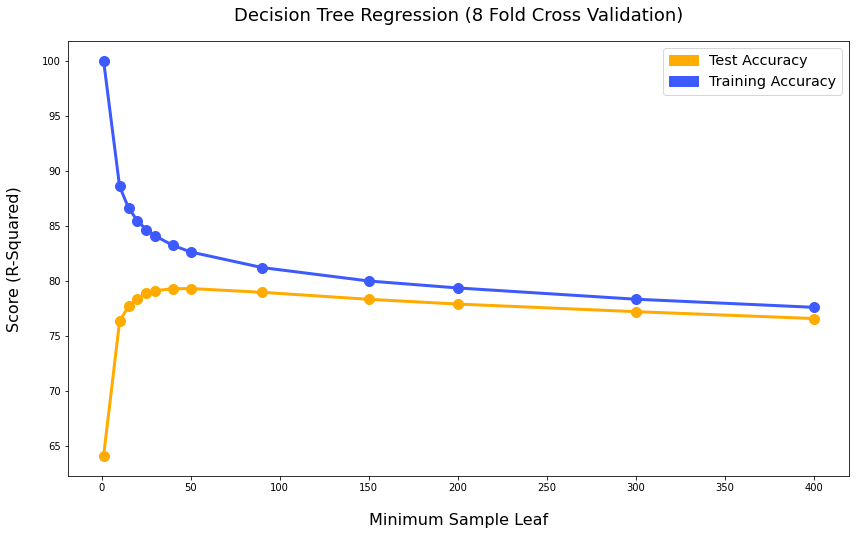

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(
  'Decision Tree Regression (8 Fold Cross Validation)', 
  fontsize=18, 
  fontweight='light', 
  pad=20
)
plt.xlabel(
  'Minimum Sample Leaf',
  fontsize=16,
  labelpad=20
)
plt.ylabel(
  'Score (R-Squared)',
  fontsize=16,
  labelpad=20
)
plt.plot(
  dt_reg_df['min_sample_leaf'], 
  dt_reg_df['mean_test_accuracy_r2'], 
  color='#ffab00', 
  linewidth=3,
  marker = ".",
  markersize=20
)

plt.plot(
  dt_reg_df['min_sample_leaf'], 
  dt_reg_df['mean_training_accuracy_r2'], 
  color='#3d5afe', 
  linewidth=3,
  marker = ".",
  markersize=20
)

plt.legend(handles=[
  mpatches.Patch(color='#ffab00', label='Test Accuracy'),
  mpatches.Patch(color='#3d5afe', label='Training Accuracy')
], fontsize="x-large")

plt.show()

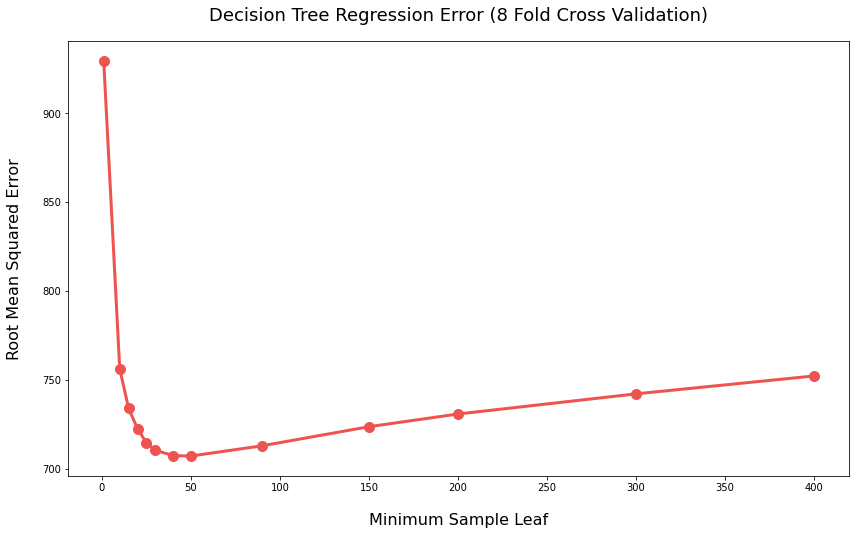

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(
  'Decision Tree Regression Error (8 Fold Cross Validation)', 
  fontsize=18, 
  fontweight='light', 
  pad=20
)
plt.xlabel(
  'Minimum Sample Leaf',
  fontsize=16,
  labelpad=20
)
plt.ylabel(
  'Root Mean Squared Error',
  fontsize=16,
  labelpad=20
)
plt.plot(
  dt_reg_df['min_sample_leaf'], 
  dt_reg_df['mean_test_accuracy_rmse'], 
  color='#ef5350', 
  linewidth=3,
  marker = ".",
  markersize=20
)

plt.show()

# Random Forest Regressor
## Cross Validate

In [ ]:
def rfregressor(X_, y_, ts, split, estimator):
  SEED = 42
  X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=ts, random_state=SEED)

  cv = KFold(
    n_splits=split,
    shuffle=True,
    random_state= SEED
  )

  rf_kfold = cross_validate(
      estimator, 
      X_train,
      y_train,
      scoring='r2', 
      cv=cv, 
      return_train_score = True, 
      n_jobs=-1
  )

  rf_kfold_mse = cross_validate(
      estimator, 
      X_train,
      y_train,
      scoring='neg_mean_squared_error', 
      cv=cv, 
      return_train_score = True, 
      n_jobs=-1
  )

  return {
      'fold': split,
      'mean_test_accuracy_r2': np.mean(np.array(rf_kfold['test_score'])) * 100,
      'mean_test_accuracy_rmse': math.sqrt(np.mean(np.array(rf_kfold_mse['test_score'])) * -1),
      'mean_training_accuracy_r2': np.mean(np.array(rf_kfold['train_score'])) * 100
  }

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
result = [
  rfregressor(X, y, 0.3, 10, RandomForestRegressor()),
  rfregressor(X, y, 0.3, 8, RandomForestRegressor()),
  rfregressor(X, y, 0.3, 6, RandomForestRegressor()),
  rfregressor(X, y, 0.3, 5, RandomForestRegressor()),
  rfregressor(X, y, 0.3, 3, RandomForestRegressor())
]

rf_reg_df = pd.DataFrame(result)
rf_reg_df

,fold,mean_test_accuracy_r2,mean_test_accuracy_rmse,mean_training_accuracy_r2
0,10,82.724058,646.994333,97.574457
1,8,82.694565,648.207661,97.570980
2,6,82.606923,647.892081,97.567861
3,5,82.606378,648.996607,97.560569
4,3,82.483684,652.758743,97.525327


In [ ]:
rf_reg_df_filtered = rf_reg_df

In [ ]:
rf_reg_df_filtered['mean_test_accuracy_r2'] = rf_reg_df_filtered['mean_test_accuracy_r2'] / 100

In [ ]:
rf_reg_df_filtered

,fold,mean_test_accuracy_r2,mean_test_accuracy_rmse,mean_training_accuracy_r2
0,10,0.827241,646.994333,97.574457
1,8,0.826946,648.207661,97.570980
2,6,0.826069,647.892081,97.567861
3,5,0.826064,648.996607,97.560569
4,3,0.824837,652.758743,97.525327


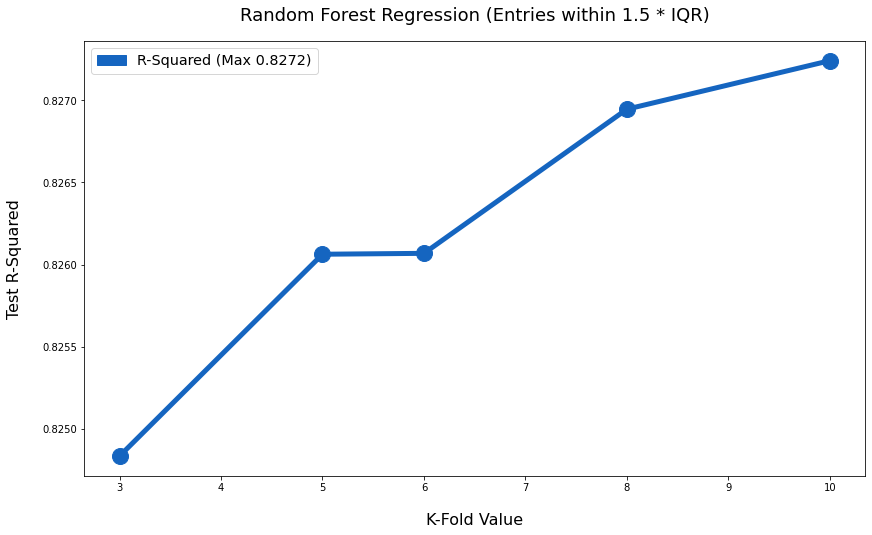

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(
  'Random Forest Regression (Entries within 1.5 * IQR)', 
  fontsize=18, 
  fontweight='light', 
  pad=20
)
plt.xlabel(
  'K-Fold Value',
  fontsize=16,
  labelpad=20
)
plt.ylabel(
  'Test R-Squared',
  fontsize=16,
  labelpad=20
)
plt.plot(
  rf_reg_df['fold'], 
  rf_reg_df['mean_test_accuracy_r2'], 
  color='#1565c0', 
  linewidth=5,
  marker = "o",
  markersize=16
)

plt.legend(handles=[
  mpatches.Patch(color='#1565c0', label='R-Squared (Max 0.8272)'),
], fontsize="x-large")

plt.show()

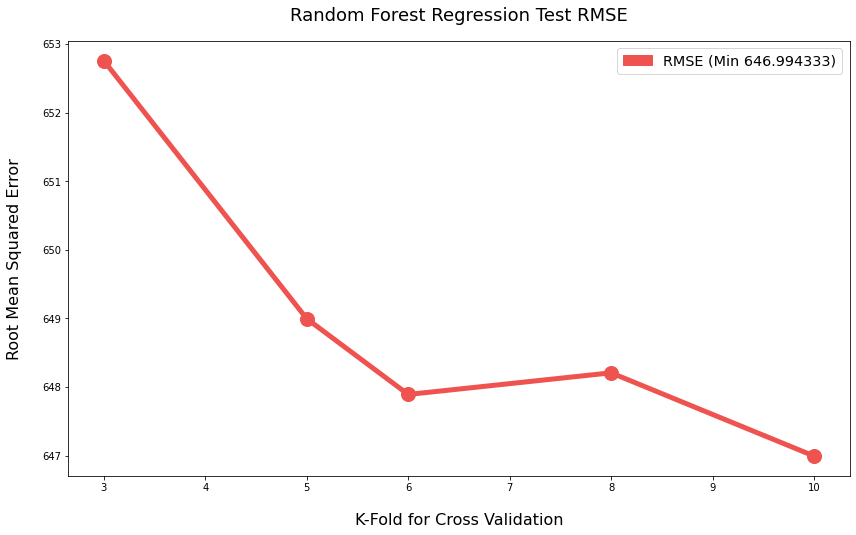

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(
  'Random Forest Regression Test RMSE', 
  fontsize=18, 
  fontweight='light', 
  pad=20
)
plt.xlabel(
  'K-Fold for Cross Validation',
  fontsize=16,
  labelpad=20
)
plt.ylabel(
  'Root Mean Squared Error',
  fontsize=16,
  labelpad=20
)
plt.plot(
  rf_reg_df['fold'], 
  rf_reg_df['mean_test_accuracy_rmse'], 
  color='#ef5350', 
  linewidth=5,
  marker = "o",
  markersize=14
)

plt.legend(handles=[
  mpatches.Patch(color='#ef5350', label='RMSE (Min 646.994333)'),
], fontsize="x-large")

plt.show()

# Train Test Split (Find Best N_Estimator)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

model = RandomForestRegressor(n_jobs=-1)
estimators = np.arange(10, 200, 10)
scores = []
rmses_train = []
rmses_test = []
r2s_train = []
r2s_test = []

for n in estimators:
  model.set_params(n_estimators=n)
  model.fit(X_train, y_train)
  scores.append(model.score(X_test, y_test))

  r_train_pred = model.predict(X_train)
  r_test_pred = model.predict(X_test)

  rmses_train.append(np.sqrt(mean_squared_error(y_train,r_train_pred)))
  rmses_test.append(mean_squared_error(y_test,r_test_pred))

  r2s_train.append(r2_score(y_train,r_train_pred))
  r2s_test.append(r2_score(y_test,r_test_pred))

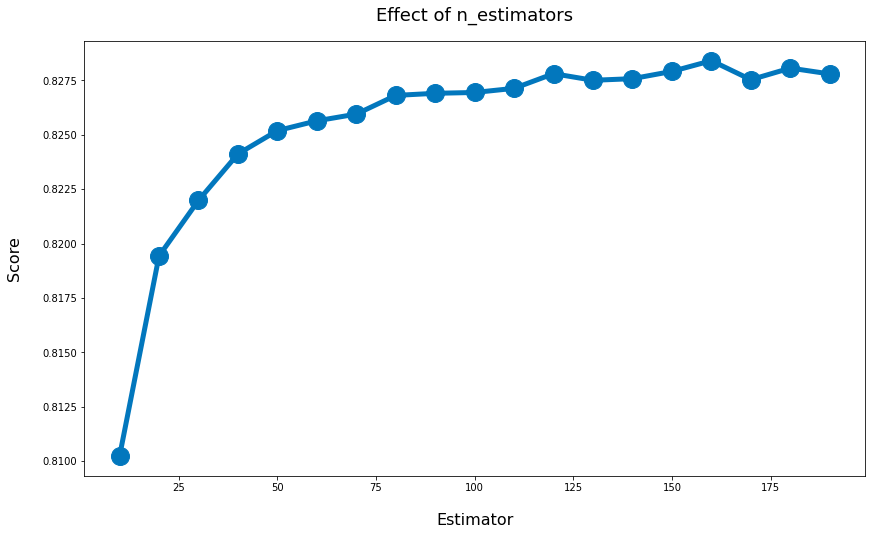

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(
  'Effect of n_estimators', 
  fontsize=18, 
  fontweight='light', 
  pad=20
)
plt.xlabel(
  'Estimator',
  fontsize=16,
  labelpad=20
)
plt.ylabel(
  'Score',
  fontsize=16,
  labelpad=20
)
plt.plot(
  estimators, scores,
  color='#0277bd', 
  linewidth=5,
  marker = "o",
  markersize=18
)

plt.show()

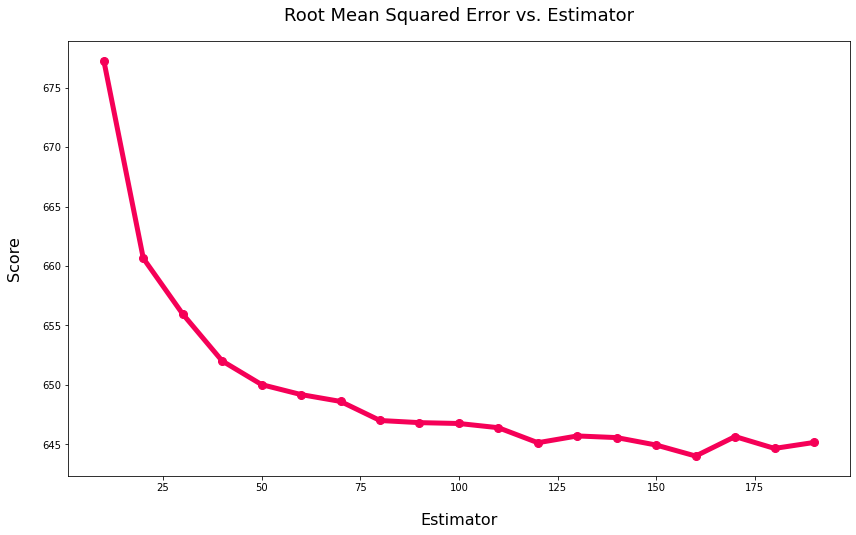

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(
  'Root Mean Squared Error vs. Estimator', 
  fontsize=18, 
  fontweight='light',
  pad=20
)
plt.xlabel(
  'Estimator',
  fontsize=16,
  labelpad=20
)
plt.ylabel(
  'Score',
  fontsize=16,
  labelpad=20
)
plt.plot(
  estimators, np.sqrt(rmses_test),
  color='#f50057', 
  linewidth=5,
  marker = ".",
  markersize=16
)

plt.show()

In [ ]:
tts_result = pd.DataFrame(
    data = {
        'estimator': estimators,
        'scores': np.array(scores) * 100,
        'rmses_test': np.sqrt(rmses_test),
        'r2s_test': r2s_test 
    }
)
tts_result = tts_result.sort_values(by = 'rmses_test', ascending=True)
tts_result

,estimator,scores,rmses_test,r2s_test
15,160,82.840914,644.008628,0.828409
17,180,82.806771,644.649045,0.828068
14,150,82.791613,644.933154,0.827916
11,120,82.781165,645.128906,0.827812
18,190,82.779987,645.150975,0.827800
13,140,82.758170,645.559528,0.827582
16,170,82.753541,645.646180,0.827535
12,130,82.750773,645.697985,0.827508
10,110,82.713718,646.391165,0.827137
9,100,82.694737,646.745943,0.826947


# Final K-Fold Building

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
SEED = 123
BEST_SPLIT = 8
BEST_ESTIMATOR = 160
BEST_DEPTH = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

cv = KFold(
  n_splits = BEST_SPLIT,
  shuffle = True,
  random_state = SEED
)


model = None
model = RandomForestRegressor(n_jobs=-1, n_estimators = BEST_ESTIMATOR)

final_rf_kfold = cross_validate(
    model, 
    X_train,
    y_train,
    scoring='r2', 
    cv=cv, 
    return_train_score = True, 
    n_jobs=-1
)

final_rf_kfold_rmse = cross_validate(
    model, 
    X_train,
    y_train,
    scoring='neg_mean_squared_error', 
    cv=cv, 
    return_train_score = True, 
    n_jobs=-1
)

final_rf_kfold_mae = cross_validate(
    model, 
    X_train,
    y_train,
    scoring='neg_mean_absolute_error', 
    cv=cv, 
    return_train_score = True, 
    n_jobs=-1
)

mean_test_accuracy = np.mean(np.array(final_rf_kfold['test_score'])) * 100
mean_training_accuracy = np.mean(np.array(final_rf_kfold['train_score'])) * 100
mean_test_accuracy_rmse = math.sqrt(np.mean(np.array(final_rf_kfold_rmse['test_score'])) * -1)
mean_test_accuracy_mae = np.mean(np.array(final_rf_kfold_mae['test_score']))

In [ ]:
(mean_test_accuracy, mean_training_accuracy)

(82.66299124749277, 97.60775526448218)

In [ ]:
mean_test_accuracy_rmse

646.7497461174108

In [ ]:
mean_test_accuracy_mae * -1

450.97578546507935